In [13]:
import mrsqm
import numpy as np
import pandas as pd
from sklearn import metrics
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import timeit

In [14]:
# code to read arff data
# Source: https://github.com/alan-turing-institute/sktime/blob/main/sktime/utils/data_io.py

def load_from_arff_to_dataframe(

    full_file_path_and_name,
    has_class_labels=True,
    return_separate_X_and_y=True,
    replace_missing_vals_with="NaN",
):
    """Load data from a .ts file into a Pandas DataFrame.
    Parameters
    ----------
    full_file_path_and_name: str
        The full pathname of the .ts file to read.
    has_class_labels: bool
        true then line contains separated strings and class value contains
        list of separated strings, check for 'return_separate_X_and_y'
        false otherwise.
    return_separate_X_and_y: bool
        true then X and Y values should be returned as separate Data Frames (
        X) and a numpy array (y), false otherwise.
        This is only relevant for data.
    replace_missing_vals_with: str
       The value that missing values in the text file should be replaced
       with prior to parsing.
    Returns
    -------
    DataFrame, ndarray
        If return_separate_X_and_y then a tuple containing a DataFrame and a
        numpy array containing the relevant time-series and corresponding
        class values.
    DataFrame
        If not return_separate_X_and_y then a single DataFrame containing
        all time-series and (if relevant) a column "class_vals" the
        associated class values.
    """
    
    instance_list = []
    class_val_list = []

    data_started = False
    is_multi_variate = False
    is_first_case = True

    # Parse the file
    # print(full_file_path_and_name)
    with open(full_file_path_and_name, "r", encoding="utf-8") as f:
        for line in f:

            if line.strip():
                if (
                    is_multi_variate is False
                    and "@attribute" in line.lower()
                    and "relational" in line.lower()
                ):
                    is_multi_variate = True

                if "@data" in line.lower():
                    data_started = True
                    continue

                # if the 'data tag has been found, the header information
                # has been cleared and now data can be loaded
                if data_started:
                    line = line.replace("?", replace_missing_vals_with)

                    if is_multi_variate:
                        if has_class_labels:
                            line, class_val = line.split("',")
                            class_val_list.append(class_val.strip())
                        dimensions = line.split("\\n")
                        dimensions[0] = dimensions[0].replace("'", "")

                        if is_first_case:
                            for _d in range(len(dimensions)):
                                instance_list.append([])
                            is_first_case = False

                        for dim in range(len(dimensions)):
                            instance_list[dim].append(
                                pd.Series(
                                    [float(i) for i in dimensions[dim].split(",")]
                                )
                            )

                    else:
                        if is_first_case:
                            instance_list.append([])
                            is_first_case = False

                        line_parts = line.split(",")
                        if has_class_labels:
                            instance_list[0].append(
                                pd.Series(
                                    [
                                        float(i)
                                        for i in line_parts[: len(line_parts) - 1]
                                    ]
                                )
                            )
                            class_val_list.append(line_parts[-1].strip())
                        else:
                            instance_list[0].append(
                                pd.Series(
                                    [float(i) for i in line_parts[: len(line_parts)]]
                                )
                            )

    x_data = pd.DataFrame(dtype=np.float32)
    for dim in range(len(instance_list)):
        x_data["dim_" + str(dim)] = instance_list[dim]

    if has_class_labels:
        if return_separate_X_and_y:
            return x_data, np.asarray(class_val_list)
        else:
            x_data["class_vals"] = pd.Series(class_val_list)

    return x_data

# code to visualize saliency map
# Source: https://github.com/mlgig/explanation4tsc/blob/master/3.%20Compare%20Metrics%20and%20Draw%20Figures.ipynb
def plot_time_series_with_color(ts, weight, save = False):   
    cas = weight
    
    def transform(X):
        ma,mi = np.max(X), np.min(X)
        X = (X - mi)/(ma-mi)
        return X*100
    cas = transform(cas)

    max_length1, max_length2 = len(weight),10000 #
    x1 = np.linspace(0,max_length1,num = max_length1)
    x2 = np.linspace(0,max_length1,num = max_length2)
    y1 = ts
    f = interp1d(x1, y1)

    fcas = interp1d(x1, cas)
    cas = fcas(x2)

    plt.figure(figsize = (5,3.5))
    plt.scatter(x2,f(x2), c = cas, cmap = 'jet', marker='.', s= 1,vmin=0,vmax = 100)    
    plt.colorbar()
    if save: plt.savefig('imgout/SM_%s_%s_Class%d_idx%d.png' %(dataset, explanation_method, label[i],i))


In [15]:
dataset="Coffee"
X_train,y_train = load_from_arff_to_dataframe("data/" + dataset + "/" + dataset + "_TRAIN.arff")
X_test,y_test = load_from_arff_to_dataframe("data/" + dataset + "/" + dataset + "_TEST.arff")

print(dataset)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Coffee
(28, 1) (28,)
(28, 1) (28,)


In [16]:
X_train

,dim_0
0,0 -0.518419 1 -0.485884 2 -0.50500...
1,0 -0.548462 1 -0.533681 2 -0.51472...
2,0 -0.472634 1 -0.415546 2 -0.35992...
3,0 -0.509521 1 -0.484218 2 -0.47795...
4,0 -0.563427 1 -0.533896 2 -0.54382...
5,0 -0.441485 1 -0.449366 2 -0.44454...
6,0 -0.496438 1 -0.465677 2 -0.41583...
7,0 -0.460578 1 -0.369229 2 -0.35411...
8,0 -0.598464 1 -0.559980 2 -0.56824...
9,0 -0.645319 1 -0.584381 2 -0.59375...


In [47]:
X_train.dim_0.apply(lambda x: len(x))

0     286
1     286
2     286
3     286
4     286
5     286
6     286
7     286
8     286
9     286
10    286
11    286
12    286
13    286
14    286
15    286
16    286
17    286
18    286
19    286
20    286
21    286
22    286
23    286
24    286
25    286
26    286
27    286
Name: dim_0, dtype: int64

In [50]:
X_train.dim_0[7]

0     -0.460578
1     -0.369229
2     -0.354116
3     -0.458597
4     -0.541036
         ...   
281   -1.989709
282   -1.991883
283   -1.994043
284   -1.997027
285   -1.999266
Length: 286, dtype: float64

## Train with MrSQMClassifier

In [20]:
clf = mrsqm.MrSQMClassifier()
try:
    clf.fit(X_train,y_train)
except Exception as e: #raise Exception(X, mr_seqs, self.sequences)
    X = e.args[0]
    mr_seqs = e.args[1]
    sequences = e.args[2]


mine
mine
mine
mine
mine
mine
mine
mine


In [26]:
clf.config

[{'method': 'sax', 'window': 16, 'word': 6, 'alphabet': 4, 'dilation': 1},
 {'method': 'sax', 'window': 16, 'word': 12, 'alphabet': 4, 'dilation': 1},
 {'method': 'sax', 'window': 64, 'word': 8, 'alphabet': 5, 'dilation': 1},
 {'method': 'sax', 'window': 64, 'word': 16, 'alphabet': 6, 'dilation': 1},
 {'method': 'sax', 'window': 256, 'word': 10, 'alphabet': 6, 'dilation': 1},
 {'method': 'sax', 'window': 128, 'word': 16, 'alphabet': 6, 'dilation': 1},
 {'method': 'sax', 'window': 32, 'word': 14, 'alphabet': 6, 'dilation': 1},
 {'method': 'sax', 'window': 64, 'word': 6, 'alphabet': 3, 'dilation': 1}]

__mr\_seql__: lista di liste

Ogni lista rappresenta una configurazione.

Ogni lista di "primo livello" è composta da altre 28 liste (= al numero di istanze)

Queste liste di "secondo livello" contengono un array di byte di lunghezza variabile.
- la lunghezza di questo array dipende dalla TS? (sono tutte lunghe 286 valori)

In [68]:
len(mr_seqs[4][0].split(b' '))

18

In [59]:
mr_seqs[0][0]

b'ddbaaa dcbbba dcbbaa dccbaa ddcbba ddccba dcccba dcccaa dcdcaa dddbaa ddcbaa ddbbaa ddbbab dcbaac dbbabd dbaabd cbaacd bbabcd baabcd aabbdd aabcdd aabccd aabbcd aabbdd aabcdd aaccdd abbcdd aabcdd aabddc aacddc aacddb abddca acddba acddaa bddcaa cddbaa ddcaba ddbbba ddbbaa dcbbaa dccbaa dccaab ddcaab ddbaba ddbbba dcbcba dcccba dcdcaa cddcaa dddbaa ddcbaa ddcaaa ddbaaa ddbaab dcaaac dbaabd cbaacd caaacd baabdd aaabdd aaacdd aabcdd aacddc abcddb abcdca acddba bcddba cddcaa cddbaa ddcbaa ddcaaa ddbaab dcaaac dbaabd cbaabd baabcd aaabdd aaacdd aabcdd aaccdd abbddd abcddc abdddc abddcb acddca bddcba cddcba dddcaa ddccaa ddcbaa ddcbba ddccaa ddcbaa ddcaaa ddbaaa ddbaab dcbaab dcaabb dbaabc dbaacd daabcd caabdd baacdd aabddd aabdcd aabccd abbbcd abbbdd ababdd aaabdd aaacdd aabcdd aacddc abcdcb abddcb acddbb acdcab bddbab bddaab cdbabc ddaabc dcabcb dbbbca dbbcca dccdca cccdba ccddaa cddcaa cddbaa dddaaa ddcaab ddbaac ddaabc dcaacc dbabdb dbbcda cbbdca cccdba ccddba ccdcba cddcaa cddbaa dddb

In [38]:
len(mr_seqs[6])

28

In [23]:
X

,dim_0
0,0 -0.518419 1 -0.485884 2 -0.50500...
1,0 -0.548462 1 -0.533681 2 -0.51472...
2,0 -0.472634 1 -0.415546 2 -0.35992...
3,0 -0.509521 1 -0.484218 2 -0.47795...
4,0 -0.563427 1 -0.533896 2 -0.54382...
5,0 -0.441485 1 -0.449366 2 -0.44454...
6,0 -0.496438 1 -0.465677 2 -0.41583...
7,0 -0.460578 1 -0.369229 2 -0.35411...
8,0 -0.598464 1 -0.559980 2 -0.56824...
9,0 -0.645319 1 -0.584381 2 -0.59375...


In [10]:
len(sequences)

8

In [13]:
len(mr_seqs[0][0])

1308

In [9]:
len(X_train)

28

## Test the model

In [6]:
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9642857142857143


## Explanation with saliency map
A saliency map is basically a weight vector for each point in the time series corresponding to a class. Higher weight means the data point is more relevant to the class according to the model.

*get_saliency_map* return a c X L array where c is the number of class and L is the length of the time series.

It is important to note that in MrSQM saliency map only works if there is at least 1 SAX representation used for training.

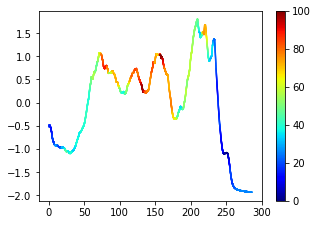

In [7]:
# This example visualise the saliency map of the 1st sample (class '0') in the Coffee dataset 
ts = X_train.iloc[0,0]
weight = clf.get_saliency_map(ts)
plot_time_series_with_color(ts, weight[0])

## Control the number of SAX and SFA representations
The parameters *nsax* and *nsfa* control the number of SAX and SFA representations produced from the raw data. The number of representations is *nsax* (or *nsfa*) x log(L) where L is the length of the time series.

Adding more representations (bigger *nsax* or *nsfa*) can improve the accuracy but slow down the training.

In [8]:
starttime = timeit.default_timer()
clf = mrsqm.MrSQMClassifier(nsax=1, nsfa=3).fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print("Time to train and predict (sec):", timeit.default_timer() - starttime)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.9642857142857143
Time to train and predict (sec): 2.2948905560042476


In [ ]:
#parameters about training that the user can change
'''     
    Overview: MrSQM is an efficient time series classifier utilizing symbolic representations of time series. MrSQM implements four different feature selection strategies (R,S,RS,SR) that can quickly select subsequences from multiple symbolic representations of time series data.
    def __init__(self, strat = 'RS', features_per_rep = 500, selection_per_rep = 2000, nsax = 1, nsfa = 0, custom_config=None, random_state = None, sfa_norm = True):

    Parameters
    ----------
    
    strat               : str, feature selection strategy, either 'R','S','SR', or 'RS'. R and S are single-stage filters while RS and SR are two-stage filters. By default set to 'RS'.
    features_per_rep    : int, (maximum) number of features selected per representation. By deafault set to 500.
    selection_per_rep   : int, (maximum) number of candidate features selected per representation. Only applied in two stages strategies (RS and SR). By deafault set to 2000.
    nsax                : int, control the number of representations produced by sax transformation.
    nsfa                : int, control the number of representations produced by sfa transformation.
    custom_config       : dict, customized parameters for the symbolic transformation.
    random_state        : set random seed for classifier. By default 'none'.
    ts_norm             : time series normalisation (standardisation). By default set to 'True'.
    '''

starttime = timeit.default_timer()
clf = mrsqm.MrSQMClassifier(random_state=42,nsax=0, nsfa=1, sfa_norm = 'False').fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print("Time to train and predict (sec):", timeit.default_timer() - starttime)


KeyboardInterrupt: 

In [10]:
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

1.0


## Explanation with saliency map
A saliency map is basically a weight vector for each point in the time series corresponding to a class. Higher weight means the data point is more relevant to the class according to the model.

*get_saliency_map* return a c X L array where c is the number of class and L is the length of the time series.

It is important to note that in MrSQM saliency map only works if there is at least 1 SAX representation used for training.

/tmp/ipykernel_263663/988184942.py:129: RuntimeWarning: invalid value encountered in true_divide
  X = (X - mi)/(ma-mi)


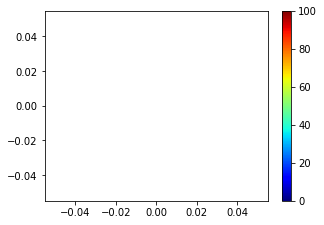

In [11]:
# This example visualise the saliency map of the 1st sample (class '0') in the Coffee dataset 
ts = X_train.iloc[0,0]
weight = clf.get_saliency_map(ts)
plot_time_series_with_color(ts, weight[0])

## Control the number of SAX and SFA representations
The parameters *nsax* and *nsfa* control the number of SAX and SFA representations produced from the raw data. The number of representations is *nsax* (or *nsfa*) x log(L) where L is the length of the time series.

Adding more representations (bigger *nsax* or *nsfa*) can improve the accuracy but slow down the training.

In [12]:
starttime = timeit.default_timer()
clf = mrsqm.MrSQMClassifier(nsax=1, nsfa=3).fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print("Time to train and predict (sec):", timeit.default_timer() - starttime)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.9642857142857143
Time to train and predict (sec): 2.0633517050009686


In [13]:
#parameters about training that the user can change
'''     
    Overview: MrSQM is an efficient time series classifier utilizing symbolic representations of time series. MrSQM implements four different feature selection strategies (R,S,RS,SR) that can quickly select subsequences from multiple symbolic representations of time series data.
    def __init__(self, strat = 'RS', features_per_rep = 500, selection_per_rep = 2000, nsax = 1, nsfa = 0, custom_config=None, random_state = None, sfa_norm = True):

    Parameters
    ----------
    
    strat               : str, feature selection strategy, either 'R','S','SR', or 'RS'. R and S are single-stage filters while RS and SR are two-stage filters. By default set to 'RS'.
    features_per_rep    : int, (maximum) number of features selected per representation. By deafault set to 500.
    selection_per_rep   : int, (maximum) number of candidate features selected per representation. Only applied in two stages strategies (RS and SR). By deafault set to 2000.
    nsax                : int, control the number of representations produced by sax transformation.
    nsfa                : int, control the number of representations produced by sfa transformation.
    custom_config       : dict, customized parameters for the symbolic transformation.
    random_state        : set random seed for classifier. By default 'none'.
    ts_norm             : time series normalisation (standardisation). By default set to 'True'.
    '''

starttime = timeit.default_timer()
clf = mrsqm.MrSQMClassifier(random_state=42,nsax=0, nsfa=1, sfa_norm = 'False').fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print("Time to train and predict (sec):", timeit.default_timer() - starttime)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[b'!\'/08:BDMOUX_b "\'.07:ADLOUX`b "\'-07:@DLOUX`b "\'-06:@DKOUX`b "\'-06:@DKOUX`b "\'-06:@DLOUX_b "\'-06:@DLOUX_b "\'-06:@DMOUX_b "\'-06:@DMOUX_b "\'-06:@EMOUX^b "\'-06:@EMOUX^b "\'-06;@EMOTX^b "\'-05;@EMNTX^b "\'-05;@ELNTX^b "\'-05;@EKNTX^b "\'-05;@EKOTY^c "\'-05;@EJOTY^c "\'-05;@EJOUY`c "\'-05;@EJOUY`b "\'-05;@EKOUY`b "\'-05;@EKOUX`b "\'-05;@ELOUX_b "\'-05<@ELOUX^b "\'-05<@EMOUX^b "\'-05<@EMOUX^b "\'-05<@EMOTX^c "\'-05<@EMOTX_c "\'-05<@EMOTX`c "\'-05<@EMOTY`b "\'-06<@ELNUY`b "\'-06<@EKNUY`b "\'-06<@EKNUY^b "\'-06<@EJOUX^b "\'-06<@EIOUX^b "\',06;@EIOUX^b "\',06;@EIOUX^c "\'+06;@EJOUX^c "\'+06;@EKOTX_c #\'+06;@ELPTX`c #\'+06;@EMPTX`b #\'+15:@EMOTY`b #\'+15:@EMOTY_b $\'+15:@EMOUY^b $\'+15:@EMOUY^b $\'+15:@EMOUY^b $\'+15;@EMNUY^c $\'+15;@ELNUX^d $\'+15;@EKNUX_d $\'+15;@EJNUXac $\'+15<@EIOUXab $\'+15<@EIOTXab $\'+15<@EIOSXab $\'+15<@DIOSX^b $\',25<@DJOSX]b $\'-45<@DKOSX]b $\'-45=@DMOSY]b $\'-45=@DMOTY]d $\'-45=@DMOUY]e $\'-46=@DMOUY_f $\'-46=@DMOUYae $\'-46<?ELOUYad $\'-46<?EKOUXac $\'-

In [14]:
#parameters about training that the user can change
'''     
    Overview: MrSQM is an efficient time series classifier utilizing symbolic representations of time series. MrSQM implements four different feature selection strategies (R,S,RS,SR) that can quickly select subsequences from multiple symbolic representations of time series data.
    def __init__(self, strat = 'RS', features_per_rep = 500, selection_per_rep = 2000, nsax = 1, nsfa = 0, custom_config=None, random_state = None, sfa_norm = True):

    Parameters
    ----------
    
    strat               : str, feature selection strategy, either 'R','S','SR', or 'RS'. R and S are single-stage filters while RS and SR are two-stage filters. By default set to 'RS'.
    features_per_rep    : int, (maximum) number of features selected per representation. By deafault set to 500.
    selection_per_rep   : int, (maximum) number of candidate features selected per representation. Only applied in two stages strategies (RS and SR). By deafault set to 2000.
    nsax                : int, control the number of representations produced by sax transformation.
    nsfa                : int, control the number of representations produced by sfa transformation.
    custom_config       : dict, customized parameters for the symbolic transformation.
    random_state        : set random seed for classifier. By default 'none'.
    ts_norm             : time series normalisation (standardisation). By default set to 'True'.
    '''

starttime = timeit.default_timer()
clf = mrsqm.MrSQMClassifier(random_state=42,nsax=0, nsfa=1, sfa_norm = 'False').fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))
print("Time to train and predict (sec):", timeit.default_timer() - starttime)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[[b'!\'/08:BDMOUX_b "\'.07:ADLOUX`b "\'-07:@DLOUX`b "\'-06:@DKOUX`b "\'-06:@DKOUX`b "\'-06:@DLOUX_b "\'-06:@DLOUX_b "\'-06:@DMOUX_b "\'-06:@DMOUX_b "\'-06:@EMOUX^b "\'-06:@EMOUX^b "\'-06;@EMOTX^b "\'-05;@EMNTX^b "\'-05;@ELNTX^b "\'-05;@EKNTX^b "\'-05;@EKOTY^c "\'-05;@EJOTY^c "\'-05;@EJOUY`c "\'-05;@EJOUY`b "\'-05;@EKOUY`b "\'-05;@EKOUX`b "\'-05;@ELOUX_b "\'-05<@ELOUX^b "\'-05<@EMOUX^b "\'-05<@EMOUX^b "\'-05<@EMOTX^c "\'-05<@EMOTX_c "\'-05<@EMOTX`c "\'-05<@EMOTY`b "\'-06<@ELNUY`b "\'-06<@EKNUY`b "\'-06<@EKNUY^b "\'-06<@EJOUX^b "\'-06<@EIOUX^b "\',06;@EIOUX^b "\',06;@EIOUX^c "\'+06;@EJOUX^c "\'+06;@EKOTX_c #\'+06;@ELPTX`c #\'+06;@EMPTX`b #\'+15:@EMOTY`b #\'+15:@EMOTY_b $\'+15:@EMOUY^b $\'+15:@EMOUY^b $\'+15:@EMOUY^b $\'+15;@EMNUY^c $\'+15;@ELNUX^d $\'+15;@EKNUX_d $\'+15;@EJNUXac $\'+15<@EIOUXab $\'+15<@EIOTXab $\'+15<@EIOSXab $\'+15<@DIOSX^b $\',25<@DJOSX]b $\'-45<@DKOSX]b $\'-45=@DMOSY]b $\'-45=@DMOTY]d $\'-45=@DMOUY]e $\'-46=@DMOUY_f $\'-46=@DMOUYae $\'-46<?ELOUYad $\'-46<?EKOUXac $\'-